https://www.learnpytorch.io/03_pytorch_computer_vision/

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [22]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

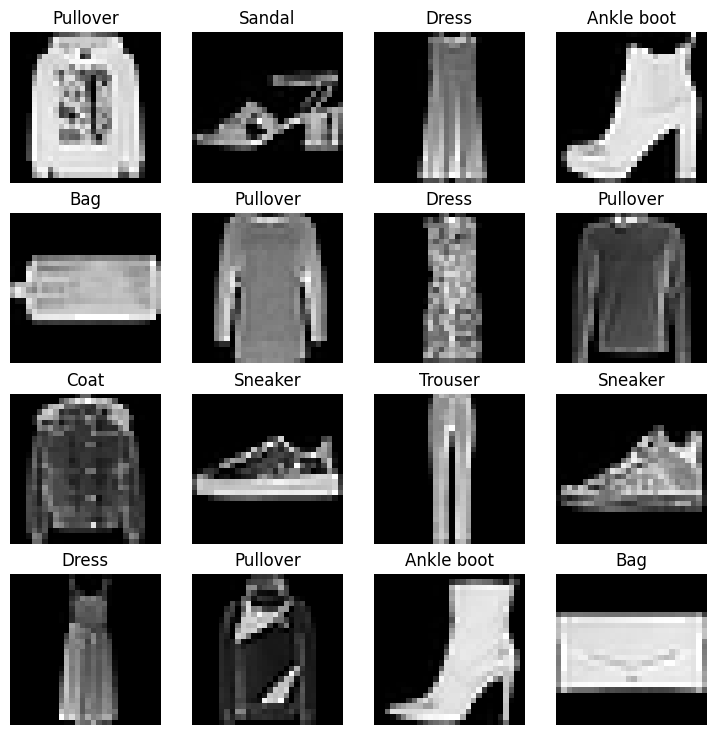

In [23]:
class_names = train_data.classes
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [24]:
batch_sz =  32
train_dataloader = DataLoader(train_data, batch_size=batch_sz, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_sz, shuffle = False) #shuffling not needed for test data
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [6]:
flatten_model = nn.Flatten()

class Net(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.Linear(hidden_units,output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [7]:
model = Net(input_shape=784, hidden_units=10, output_shape=len(class_names))

x = train_features_batch[0]
x2 = flatten_model(x) #for some reason using nn.Flatten(x) directly didnt work?
x.shape, x2.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [25]:
from timeit import default_timer as timer
def print_time(start: float, end: float):
  print(f"Train time: {(end-start):.3f} seconds")
  return end-start
start_time = timer()
end_time = timer()
print_time(start_time, end_time)

Train time: 0.000 seconds


2.9275000088091474e-05

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)
def accuracy_fn(y_true, y_pred):
  count = torch.eq(y_true, y_pred).sum().item()
  return (count/len(y_pred))*100
from tqdm.auto import tqdm
start_time = timer()
epochs = 3
for epoch in tqdm(range(epochs)): #!!tqdm has no practical use; just fun progress bar -> can be removed
  print(f"Epoch: {epoch}\n---------")
  train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
  test_step(test_dataloader, model, loss_fn, accuracy_fn)
end_time = timer()
print_time(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.48263 | Train accuracy: 83.43%
Test loss: 0.50602 | Test accuracy: 82.37%

Epoch: 1
---------
Train loss: 0.46399 | Train accuracy: 83.96%
Test loss: 0.48656 | Test accuracy: 83.01%

Epoch: 2
---------
Train loss: 0.45204 | Train accuracy: 84.34%
Test loss: 0.47588 | Test accuracy: 83.18%

Train time: 29.745 seconds


29.745168571000022

https://poloclub.github.io/cnn-explainer/

In [33]:
class CNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units,hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*14*14, output_shape) #find the out value from pytorch website
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    #x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [40]:
model2 = CNN(1, 10, len(class_names)).to(device)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2.parameters(), lr = 0.1) #RECOMAND FOARTE TARE CAND RESCRII OPTIMIZERU SA AI CREIER DESTUL SA SCHIMBI PARAMETERS HAHAHAHAHBAHAHA
epochs = 3
for epoch in tqdm(range(epochs)):
  start_time = timer()
  print(f"Epoch: {epoch}\n-----")
  train_step(model2, train_dataloader, loss_fn, optimizer, accuracy_fn)
  test_step(train_dataloader, model2, loss_fn, accuracy_fn)
  end_time = timer()
  print_time(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 0.47246 | Train accuracy: 83.60%
Test loss: 0.33487 | Test accuracy: 88.33%

Train time: 16.852 seconds
Epoch: 1
-----
Train loss: 0.32301 | Train accuracy: 88.54%
Test loss: 0.28007 | Test accuracy: 90.06%

Train time: 19.164 seconds
Epoch: 2
-----
Train loss: 0.28976 | Train accuracy: 89.60%
Test loss: 0.27605 | Test accuracy: 89.95%

Train time: 16.162 seconds
